In [1]:
import torch
import torch.nn as nn
import time
import argparse

import os
import datetime

from torch.distributions.categorical import Categorical

# visualization 
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

device = torch.device("cpu"); gpu_id = -1 # select CPU

gpu_id = '0' # select a single GPU  
#gpu_id = '2,3' # select multiple GPUs  
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)  
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('GPU name: {:s}, gpu_id: {:s}'.format(torch.cuda.get_device_name(0),gpu_id))   
    
print(device)
print('pytorch version = ',torch.__version__)

cpu
pytorch version =  1.10.0


In [2]:
import math
import numpy as np
import torch.nn.functional as F
import random
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
class TransEncoderNet(nn.Module):
    """
    Encoder network based on self-attention transformer
    Inputs :  
      h of size      (bsz, nb_nodes, dim_emb)    batch of input cities
    Outputs :  
      h of size      (bsz, nb_nodes, dim_emb)    batch of encoded cities
      score of size  (bsz, nb_nodes, nb_nodes+1) batch of attention scores
    """
    
    def __init__(self, nb_layers, dim_emb, nb_heads, dim_ff, batchnorm):
        super(TransEncoderNet, self).__init__()
        assert dim_emb == nb_heads* (dim_emb//nb_heads) # check if dim_emb is divisible by nb_heads
        self.MHA_layers = nn.ModuleList( [nn.MultiheadAttention(dim_emb, nb_heads) for _ in range(nb_layers)] )
        self.linear1_layers = nn.ModuleList( [nn.Linear(dim_emb, dim_ff) for _ in range(nb_layers)] )
        self.linear2_layers = nn.ModuleList( [nn.Linear(dim_ff, dim_emb) for _ in range(nb_layers)] )   
        if batchnorm:
            self.norm1_layers = nn.ModuleList( [nn.BatchNorm1d(dim_emb) for _ in range(nb_layers)] )
            self.norm2_layers = nn.ModuleList( [nn.BatchNorm1d(dim_emb) for _ in range(nb_layers)] )
        else:
            self.norm1_layers = nn.ModuleList( [nn.LayerNorm(dim_emb) for _ in range(nb_layers)] )
            self.norm2_layers = nn.ModuleList( [nn.LayerNorm(dim_emb) for _ in range(nb_layers)] )
        self.nb_layers = nb_layers
        self.nb_heads = nb_heads
        self.batchnorm = batchnorm
        
    def forward(self, h):      
        # PyTorch nn.MultiheadAttention requires input size (seq_len, bsz, dim_emb) 
        h = h.transpose(0,1) # size(h)=(nb_nodes, bsz, dim_emb)  
        # L layers
        for i in range(self.nb_layers):
            h_rc = h # residual connection, size(h_rc)=(nb_nodes, bsz, dim_emb)
            h, score = self.MHA_layers[i](h, h, h) # size(h)=(nb_nodes, bsz, dim_emb), size(score)=(bsz, nb_nodes, nb_nodes)
            # add residual connection
            
            h = h_rc + h # size(h)=(nb_nodes, bsz, dim_emb)
            if self.batchnorm:
                # Pytorch nn.BatchNorm1d requires input size (bsz, dim, seq_len)
                h = h.permute(1,2,0).contiguous() # size(h)=(bsz, dim_emb, nb_nodes)
                h = self.norm1_layers[i](h)       # size(h)=(bsz, dim_emb, nb_nodes)
                h = h.permute(2,0,1).contiguous() # size(h)=(nb_nodes, bsz, dim_emb)
            else:
                h = self.norm1_layers[i](h)       # size(h)=(nb_nodes, bsz, dim_emb) 
            # feedforward
            h_rc = h # residual connection
            h = self.linear2_layers[i](torch.relu(self.linear1_layers[i](h)))
            h = h_rc + h # size(h)=(nb_nodes, bsz, dim_emb)
            if self.batchnorm:
                h = h.permute(1,2,0).contiguous() # size(h)=(bsz, dim_emb, nb_nodes)
                h = self.norm2_layers[i](h)       # size(h)=(bsz, dim_emb, nb_nodes)
                h = h.permute(2,0,1).contiguous() # size(h)=(nb_nodes, bsz, dim_emb)
            else:
                h = self.norm2_layers[i](h) # size(h)=(nb_nodes, bsz, dim_emb)
        # Transpose h
        h = h.transpose(0,1) # size(h)=(bsz, nb_nodes, dim_emb)
        return h, score
    

class Attention(nn.Module):
    def __init__(self, n_hidden):
        super(Attention, self).__init__()
        self.size = 0
        self.batch_size = 0
        self.dim = n_hidden
        
        v  = torch.FloatTensor(n_hidden)
        self.v  = nn.Parameter(v)
        self.v.data.uniform_(-1/math.sqrt(n_hidden), 1/math.sqrt(n_hidden))
        
        # parameters for pointer attention
        self.Wref = nn.Linear(n_hidden, n_hidden)
        self.Wq = nn.Linear(n_hidden, n_hidden)
    
    
    def forward(self, q, ref):       # query and reference
        self.batch_size = q.size(0)
        self.size = int(ref.size(0) / self.batch_size)
        q = self.Wq(q)     # (B, dim)
        ref = self.Wref(ref)
        ref = ref.view(self.batch_size, self.size, self.dim)  # (B, size, dim)
        
        q_ex = q.unsqueeze(1).repeat(1, self.size, 1) # (B, size, dim)
        # v_view: (B, dim, 1)
        v_view = self.v.unsqueeze(0).expand(self.batch_size, self.dim).unsqueeze(2)
        
        # (B, size, dim) * (B, dim, 1)
        u = torch.bmm(torch.tanh(q_ex + ref), v_view).squeeze(2)
        
        return u, ref
    
class LSTM(nn.Module):
    def __init__(self, n_hidden):
        super(LSTM, self).__init__()
        
        # parameters for input gate
        self.Wxi = nn.Linear(n_hidden, n_hidden)    # W(xt)
        self.Whi = nn.Linear(n_hidden, n_hidden)    # W(ht)
        self.wci = nn.Linear(n_hidden, n_hidden)    # w(ct)
        
        # parameters for forget gate
        self.Wxf = nn.Linear(n_hidden, n_hidden)    # W(xt)
        self.Whf = nn.Linear(n_hidden, n_hidden)    # W(ht)
        self.wcf = nn.Linear(n_hidden, n_hidden)    # w(ct)
        
        # parameters for cell gate
        self.Wxc = nn.Linear(n_hidden, n_hidden)    # W(xt)
        self.Whc = nn.Linear(n_hidden, n_hidden)    # W(ht)
        
        # parameters for forget gate
        self.Wxo = nn.Linear(n_hidden, n_hidden)    # W(xt)
        self.Who = nn.Linear(n_hidden, n_hidden)    # W(ht)
        self.wco = nn.Linear(n_hidden, n_hidden)    # w(ct)
    
    
    def forward(self, x, h, c):       # query and reference
        
        # input gate
        i = torch.sigmoid(self.Wxi(x) + self.Whi(h) + self.wci(c))
        # forget gate
        f = torch.sigmoid(self.Wxf(x) + self.Whf(h) + self.wcf(c))
        # cell gate
        c = f * c + i * torch.tanh(self.Wxc(x) + self.Whc(h))
        # output gate
        o = torch.sigmoid(self.Wxo(x) + self.Who(h) + self.wco(c))
        
        h = o * torch.tanh(c)
        
        return h, c

class HPN(nn.Module):
    def __init__(self, n_feature, n_hidden):

        super(HPN, self).__init__()
        self.city_size = 0
        self.batch_size = 0
        self.dim = n_hidden
        
        # lstm for first turn
        #self.lstm0 = nn.LSTM(n_hidden, n_hidden)
        
        # pointer layer
        self.pointer = Attention(n_hidden)
        self.TransPointer = Attention(n_hidden)
        
        # lstm encoder
        self.encoder = LSTM(n_hidden)
        
        # trainable first hidden input
        h0 = torch.FloatTensor(n_hidden)
        c0 = torch.FloatTensor(n_hidden)
        # trainable latent variable coefficient
        print('here') 
        alpha = torch.ones(1)       
        self.h0 = nn.Parameter(h0)
        self.c0 = nn.Parameter(c0)
        
        self.alpha = nn.Parameter(alpha)
        self.h0.data.uniform_(-1/math.sqrt(n_hidden), 1/math.sqrt(n_hidden))
        self.c0.data.uniform_(-1/math.sqrt(n_hidden), 1/math.sqrt(n_hidden))
        
        r1 = torch.ones(1)
        r2 = torch.ones(1)
        r3 = torch.ones(1)
        self.r1 = nn.Parameter(r1)
        self.r2 = nn.Parameter(r2)
        self.r3 = nn.Parameter(r3)
        
        # embedding
        self.embedding_x = nn.Linear(n_feature, n_hidden)
        self.embedding_all = nn.Linear(n_feature, n_hidden)
        self.Transembedding_all = TransEncoderNet(6, 128, 8, 512, batchnorm=True)#6,128,8,512
        
        # vector to start decoding 
        self.start_placeholder = nn.Parameter(torch.randn(n_hidden))
        
        # weights for GNN
        self.W1 = nn.Linear(n_hidden, n_hidden)
        self.W2 = nn.Linear(n_hidden, n_hidden)
        self.W3 = nn.Linear(n_hidden, n_hidden)
        
        # aggregation function for GNN
        self.agg_1 = nn.Linear(n_hidden, n_hidden)
        self.agg_2 = nn.Linear(n_hidden, n_hidden)
        self.agg_3 = nn.Linear(n_hidden, n_hidden)
    
    
    def forward(self,context,Transcontext, x, X_all, mask, h=None, c=None, latent=None):
        '''
        Inputs (B: batch size, size: city size, dim: hidden dimension)
        
        x: current city coordinate (B, 2)
        X_all: all cities' cooridnates (B, size, 2)
        mask: mask visited cities
        h: hidden variable (B, dim)
        c: cell gate (B, dim)
        latent: latent pointer vector from previous layer (B, size, dim)
        
        Outputs
        
        softmax: probability distribution of next city (B, size)
        h: hidden variable (B, dim)
        c: cell gate (B, dim)
        latent_u: latent pointer vector for next layer
        '''
        
        self.batch_size = X_all.size(0)
        self.city_size = X_all.size(1)
        
        # Check if this the first iteration loop
        if h is None or c is None:
            x          = self.start_placeholder    
            context = self.embedding_all(X_all)
            Transcontext,_ = self.Transembedding_all(context)
            
            # =============================
            # graph neural network encoder
            # =============================

            # (B, size, dim)
            context = context.reshape(-1, self.dim)
            Transcontext = Transcontext.reshape(-1, self.dim)

            context = self.r1 * self.W1(context)\
                + (1-self.r1) * F.relu(self.agg_1(context/(self.city_size-1)))

            context = self.r2 * self.W2(context)\
                + (1-self.r2) * F.relu(self.agg_2(context/(self.city_size-1)))

            context = self.r3 * self.W3(context)\
                + (1-self.r3) * F.relu(self.agg_3(context/(self.city_size-1)))
            h0 = self.h0.unsqueeze(0).expand(self.batch_size, self.dim)
            c0 = self.c0.unsqueeze(0).expand(self.batch_size, self.dim)

            h0 = h0.unsqueeze(0).contiguous()
            c0 = c0.unsqueeze(0).contiguous()
            
            # let h0, c0 be the hidden variable of first turn
            h = h0.squeeze(0)
            c = c0.squeeze(0)
        else:
            x          = self.embedding_x(x)
        # LSTM encoder1900/2500
        h, c = self.encoder(x, h, c)
        # query vector
        q = h
        # pointer
        u1, _ = self.pointer(q, context)
        u2 ,_ = self.TransPointer(q,Transcontext)
        # Avg Agg between the two attention vectors
        u = u2 #torch.maximum(u1,u2)
        latent_u = u.clone()
        u = 10 * torch.tanh(u) + mask
        return context,Transcontext,F.softmax(u, dim=1), h, c, latent_u

# daniel rectangle feature handle

In [3]:
'''
This part I designed the rectangle-characterized TSP, that means for every step the agent walk through a corner,
then he travel through the whole rectangle using zig-zag, finally he ends up at one of the rest corners of 
the rextangle, so, it equals the agent walk through three points at one step, in practice, I add three points into 
mask to make them unselectable.
'''
def rectangle_process(idx_recorder,f_temp,idx,Y,Y0,mask,k,B):
    Y1 = Y[zero_to_bsz, idx.data].clone()
    rectangle_inf = idx/4
    feature_table = f_temp.outcorner_getout(rectangle_inf,B)
    feature_table = torch.Tensor(feature_table).type(torch.long)
    Y_corner = Y[zero_to_bsz, feature_table[:,0].data].clone()
    path_gazebo.append([idx.data[0].tolist(),feature_table[:,0].data[0].tolist()])
    idx_recorder.append(feature_table[:,0][0].data)
    if k ==0:
        reward = 0
    if k > 0:
        reward = torch.sum((Y1 - Y0)**2 , dim=1 )**0.5
        reward += torch.sum((Y_corner - Y1)**2 , dim=1 )**0.5
#         dis = (Y1 - Y0)**2
#         dis_1 = (Y_corner - Y1)**2
#         reward = torch.maximum(dis[:,0],dis[:,1])**0.5
#         reward += torch.maximum(dis_1[:,0],dis_1[:,1])**0.5  
    mask[zero_to_bsz, idx.data] += -np.inf
    mask[zero_to_bsz, feature_table[:,0].data] += -np.inf
    mask[zero_to_bsz, feature_table[:,1].data] += -np.inf    
    mask[zero_to_bsz, feature_table[:,2].data] += -np.inf 
    return reward, Y_corner, Y_corner
def rectangle_process_actor(f_temp,idx,Y,Y0,mask,k,B,i,path_gazebo):
    Y1 = Y[zero_to_bsz, idx.data].clone()
    rectangle_inf = idx/4
    feature_table = f_temp.outcorner_getout(rectangle_inf,B)
    feature_table = torch.Tensor(feature_table).type(torch.long)
    Y_corner = Y[zero_to_bsz, feature_table[:,0].data].clone()
    if k ==0:
        reward = 0
    if k > 0:
        reward = torch.sum((Y1 - Y0)**2 , dim=1 )**0.5
        reward += torch.sum((Y_corner - Y1)**2 , dim=1 )**0.5
#         dis = (Y1 - Y0)**2
#         dis_1 = (Y_corner - Y1)**2
#         reward = torch.maximum(dis[:,0],dis[:,1])**0.5
#         reward += torch.maximum(dis_1[:,0],dis_1[:,1])**0.5  
    mask[zero_to_bsz, idx.data] += -np.inf
    mask[zero_to_bsz, feature_table[:,0].data] += -np.inf
    mask[zero_to_bsz, feature_table[:,1].data ] += -np.inf    
    mask[zero_to_bsz, feature_table[:,2].data ] += -np.inf 
    return reward, Y_corner, Y_corner

prepare to train
Hyper parameters:
learning rate 0.0001
batch size 1
steps 1
epoch 1
here
here
Re-start training with saved checkpoint file=checkpoint/HPN_R_BASED_25_1.pkl
  Checkpoint at epoch= 18 and time=1024.814min

tensor([2885.0122])
epoch:19, batch:1/1, reward:3058.072998046875


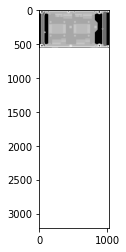

record the last path to gazebo for showing up


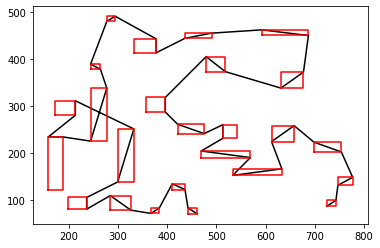

[[80, 82], [24, 26], [53, 55], [58, 56], [2, 0], [85, 87], [32, 35], [61, 63], [45, 46], [91, 89], [92, 94], [21, 23], [70, 68], [29, 30], [50, 48], [75, 73], [98, 96], [38, 39], [9, 10], [42, 40], [6, 5], [79, 77], [16, 18], [15, 13], [67, 65]]


In [4]:
import yaml
from torch.distributions.categorical import Categorical
# visualization
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm_notebook
####### my own import file ##########
from listofpathpoint import input_handler
import cnc_input
#from hybrid_models import HPN
####### my own import file ##########
'''
so, the models we have are TransEncoderNet,
                            Attention
                            LSTM
                            HPN
each one have initial parameters and the forward part, 
once we have the forward part, the back propagation will 
finished automatically by pytorch  
'''
size = 100
TOL = 1e-3
TINY = 1e-15
learning_rate = 1e-4   #learning rate
B = 1             #batch size
B_valLoop = 20
steps = 1
n_epoch = 1       # epochs
size_rec = int(size/4)
record_actor = []
record_critic = []

print('======================')
print('prepare to train')
print('======================')
print('Hyper parameters:')
print('learning rate', learning_rate)
print('batch size', B)
print('steps', steps)
print('epoch', n_epoch)
print('======================')

'''
instantiate a training network and a baseline network
'''
temp = input_handler('10&15data/25_chips/25_1.json')

try:
    del Actor  # remove existing model
    del Critic # remove existing model
except:
    pass
Actor = HPN(n_feature = 2, n_hidden = 128)
Critic = HPN(n_feature = 2, n_hidden = 128)
optimizer = optim.Adam(Actor.parameters(), lr=learning_rate)

# Putting Critic model on the eval mode
Actor = Actor.to(device)
Critic = Critic.to(device)
Critic.eval()

epoch_ckpt = 0
tot_time_ckpt = 0

val_mean = []
val_std = []

plot_performance_train = []
plot_performance_baseline = []
# recording the result of the resent epoch makes it available for future
#*********************# Uncomment these lines to load the previous check point

checkpoint_file = "checkpoint/HPN_R_BASED_25_1.pkl"
checkpoint = torch.load(checkpoint_file, map_location=device)
epoch_ckpt = checkpoint['epoch'] + 1
tot_time_ckpt = checkpoint['tot_time']
plot_performance_train = checkpoint['plot_performance_train']
plot_performance_baseline = checkpoint['plot_performance_baseline']
Critic.load_state_dict(checkpoint['model_baseline'])
Actor.load_state_dict(checkpoint['model_train'])
optimizer.load_state_dict(checkpoint['optimizer'])

print('Re-start training with saved checkpoint file={:s}\n  Checkpoint at epoch= {:d} and time={:.3f}min\n'.format(checkpoint_file,epoch_ckpt-1,tot_time_ckpt/60))


#***********************# Uncomment these lines to load the previous check point

# Main training loop
# The core training concept mainly upon Sampling from the actor
# then taking the greedy action from the critic


start_training_time = time.time()
time_stamp = datetime.datetime.now().strftime("%y-%m-%d--%H-%M-%S") # Load the time stamp

C = 0       # baseline => the object which the actor can compare
R = 0       # reward

zero_to_bsz = torch.arange(B, device = device) # a list contains 0 to (batch size -1)

for epoch in range(0, n_epoch):
    
    # re-start training with saved checkpoint
    epoch += epoch_ckpt # adding the number of the former epochs
    # Train the model for one epoch
    start = time.time() # record the starting time
    Actor.train() 
    X_temp = temp.every_point()
    X_temp = torch.FloatTensor(X_temp)
    f_temp = input_handler('10&15data/25_chips/25_1.json')
    X = X_temp.repeat(B,1,1)
    if torch.cuda.is_available():    
        X = X.cuda()
    path_gazebo = []
    
    for i in range(1, steps+1): # 1 ~ 2500 steps
        if torch.cuda.is_available():
            mask = torch.zeros(B,size).cuda() # use mask to make some points impossible to choose
        else:
            mask = torch.zeros(B,size)
        R = 0
        logprobs = 0
        reward = 0
        Y = X.view(B,size,2)
        x = torch.zeros(B,2)#Y[:,0,:] #set the first point to x
        h = None
        c = None
        context = None        #set Y_ini to the out corner
        Transcontext = None
        Y0 = None
        # Actor Sampling phase
        for k in range(size_rec):
            context, Transcontext, output, h, c, _ = Actor(context,Transcontext,x=x, X_all=X, h=h, c=c, mask=mask)
            sampler = torch.distributions.Categorical(output)
            idx = sampler.sample()
             #prepare for the back propagation of pytorch
            reward, Y0,x = rectangle_process_actor(f_temp, idx,Y,Y0,mask,k,B,i,path_gazebo)
            R += reward
            logprobs += torch.log(output[zero_to_bsz, idx.data] + TINY)
            ##mask[zero_to_bsz, idx.data] += -np.inf
# critic baseline phase, use the baseline to compute the actual reward of agent at that time
        if torch.cuda.is_available():
            mask = torch.zeros(B,size).cuda() # use mask to make some points impossible to choose
        else:
            mask = torch.zeros(B,size)
        C = 0
        baseline = 0
        Y = X.view(B,size,2)
        x = torch.zeros(B,2)#Y[:,0,:] #set the first point to x
        h = None
        c = None
        context = None
        Transcontext = None
        C0 = None
        idx_recorder = []
        # compute tours for baseline without grad "Cause we want to fix the weights for the critic"
        with torch.no_grad():
            for k in range(size_rec):      
                context, Transcontext, output, h, c, _ = Critic(context,Transcontext,x=x, X_all=X, h=h, c=c, mask=mask)
                idx = torch.argmax(output, dim=1) # ----> greedy baseline critic
                idx_recorder.append(idx[0])
                # prepare for the back propagation of pytorch
                baseline, C0,x = rectangle_process(idx_recorder,f_temp,idx,Y,C0, mask,k,B)
                C += baseline
        print(C)
        ###################
        # Loss and backprop handling 
        ###################
        loss = torch.mean((R - C) * logprobs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 1 == 0:
            print("epoch:{}, batch:{}/{}, reward:{}".format(epoch, i, steps,R.mean().item()))
            record_actor.append(R.mean().tolist())
            record_critic.append(C.tolist())
            plt.plot(record_actor,'r:')
            plt.plot(record_critic,'b:')
            plt.show()
        if i % 1 == 0:
            print("record the last path to gazebo for showing up")
            #starting to show the path on simulated enviroment of cnc_machine 
            the_resent_path = temp.zig_zag_path(path_gazebo)
            print(path_gazebo)
            data = {'path':the_resent_path}
            data_1 = {'corners':path_gazebo}


  




                
            
                
        
                        

# dynamic programing part, find a waiting time path

In [5]:
def rectangle_type(idx_list):
    rec_type = [0]*int(len(idx_list)/2)
    for idx1,idx2 in zip(idx_list[0::2], idx_list[1::2]):
        if abs(idx1 - idx2)==1:
            if (idx1%4 == 1 and idx2%4 == 2)or(idx1%4 ==2 and idx2%4 == 1):
                rec_type[int(idx1/4)] = 3
            else:
                rec_type[int(idx1/4)] = 1
        elif abs(idx1 - idx2)==2:
            rec_type[int(idx1/4)] = 2
        elif abs(idx1 - idx2)==3:
            rec_type[int(idx1/4)] = 3
    return rec_type
def euc_dis(point1,point2):
    return ((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2)**0.5
def calculate_distance(idx_list, eucli_data):
    C=0
    reward_record = [0]
    for i in range(len(idx_list)-1):
        dis = euc_dis(eucli_data[idx_list[i]],eucli_data[idx_list[i+1]])
        C += dis
        reward_record.append(C)
    return reward_record
def calculate_wait_time(idx_list, reward_record,waiting_time,visit_count_rec):
    idx_time = zip(idx_list,reward_record)
    idx_time = sorted(idx_time, key=lambda x: x[0])
    total_idx = 0
    extra_waiting_time = 0
    for item in visit_count_rec:
        compare_list = []
        if item>1:
            for i in range(int(item)):
                compare_list.append(idx_time[int(total_idx + i)][1])
            compare_list.sort(reverse=True)
            total_idx += item
            for i in range(len(compare_list)-1):
                dis_step = compare_list[i] - compare_list[i+1]
                dry_time = waiting_time
                if (dis_step) < (dry_time):
                    extra_waiting_time += dry_time - dis_step
        else:
            total_idx += item
    return extra_waiting_time
def pair_recpath(index):
    if index[0]%4 ==0:
        if rec_type[int(index[0]/4)] == 1:
            index.append(index[0]+1)
        if rec_type[int(index[0]/4)] == 2:
            index.append(index[0]+2)
        if rec_type[int(index[0]/4)] == 3:
            index.append(index[0]+3)
    if index[0]%4 ==1:
        if rec_type[int(index[0]/4)] == 1:
            index.append(index[0]-1)
        if rec_type[int(index[0]/4)] == 2:
            index.append(index[0]+2)
        if rec_type[int(index[0]/4)] == 3:
            index.append(index[0]+1)    
    if index[0]%4 ==2:
        if rec_type[int(index[0]/4)] == 1:
            index.append(index[0]+1)
        if rec_type[int(index[0]/4)] == 2:
            index.append(index[0]-2)
        if rec_type[int(index[0]/4)] == 3:
            index.append(index[0]-1)  
    if index[0]%4 ==3:
        if rec_type[int(index[0]/4)] == 1:
            index.append(index[0]-1)
        if rec_type[int(index[0]/4)] == 2:
            index.append(index[0]-2)
        if rec_type[int(index[0]/4)] == 3:
            index.append(index[0]-3) 
    return index

[80 82 24 26 53 55 58 56  2  0 85 87 32 35 61 63 45 46 91 89 92 94 21 23
 70 68 29 30 50 48 75 73 98 96 38 39  9 10 42 40  6  5 79 77 16 18 15 13
 67 65]
[1, 2, 1, 3, 3, 3, 3, 1, 1, 3, 2, 2, 3, 3, 1, 1, 2, 2, 3, 2, 3, 2, 2, 3, 3]
[82 80 80 82 24 26 80 82 25 27 53 55 55 53 26 24 53 55 58 56  2  0 85 87
 87 85 32 35 61 63 45 46 46 45 89 91 91 89 92 94 94 92 92 94 23 21 21 23
 23 21 70 68 68 70 29 30 50 48 48 50 50 48 75 73 73 75 75 73 98 96 38 39
 96 98 39 38  9 10 99 97 42 40 78 76  6  5 36 37  5  6 79 77 18 16 16 18
 13 15 41 43 15 13 18 16 14 12 65 67 67 65]
6385.0063747147615


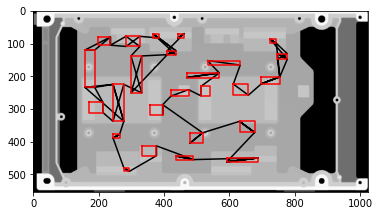

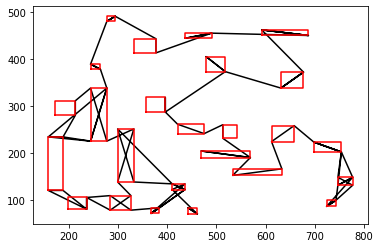

In [6]:
import copy
data_dimension = 4
waiting_time = 150
ROI_num = 25
idx_recorder = torch.tensor(idx_recorder)
idx_list = idx_recorder.tolist()
idx_list_np = np.array(idx_list)
print(idx_list_np)
rec_type = rectangle_type(idx_list)
reward_recorder = []
data_generate = input_handler('10&15data/25_chips/25_1.json')
data_visit = data_generate.final_ver_points()
data_visit = np.array(data_visit[0])
data_visit = data_visit.reshape(int(len(data_visit)/4),4,4)
eucli_data = data_generate.every_point()
visit_time = data_visit[:,:,data_dimension-1]
visit_time = visit_time[:,0]
max_visit_time = max(visit_time)
visit_time_rec = [1]*ROI_num
total_reward = None
for i in range(2,max_visit_time+1):
    for rectangle_path in data_visit:
        less_cost_idx = None
        if rectangle_path[0][data_dimension-1] >= i:
            corner = 0
            inter_leave_perform = []
            for path in rectangle_path:
                idx_list = idx_list_np.tolist()
                index = [path[data_dimension-2]*4+corner]
                index = pair_recpath(index)
                perform_buffer = [0]*int(len(idx_list)/2)
                for j in range(0,len(idx_list),2):
                    idx_list = idx_list_np.tolist()
                    idx_list.insert(j,index[0])
                    idx_list.insert(j+1,index[1])
                    # start to calculate the total reward
                    reward_record = calculate_distance(idx_list,eucli_data)
                    visit_time_rec[int(index[0]/4)] += 1
                    extra_time = calculate_wait_time(idx_list,reward_record,waiting_time,visit_time_rec)
                    perform_buffer[int(j/2)] = reward_record[-1] + extra_time
                    visit_time_rec[int(index[0]/4)] -= 1
                min_reward = min(perform_buffer)
                inter_leave_perform.append([min_reward,perform_buffer.index(min_reward),index])
                corner+=1
            inter_leave_perform = sorted(inter_leave_perform, key=lambda x: x[0])
            total_reward = inter_leave_perform[0][0]
            less_cost_idx = inter_leave_perform[0][1]*2
            idx_list_np = np.insert(idx_list_np, less_cost_idx, inter_leave_perform[0][2][0])
            idx_list_np = np.insert(idx_list_np, less_cost_idx+1, inter_leave_perform[0][2][1])
            visit_time_rec[int(inter_leave_perform[0][2][0]/4)] += 1
print(visit_time_rec)
print(idx_list_np)
print(total_reward)
idx_path_gazebo = []
for idx1,idx2 in zip(idx_list_np[0::2], idx_list_np[1::2]):
    idx_path_gazebo.append([idx1,idx2])
the_resent_path = data_generate.zig_zag_path(idx_path_gazebo)
the_resent_path = data_generate.zig_zag_path(idx_path_gazebo)

In [7]:
import torch
index = int(9.34)
table = [[1,2],[3,4]]
table_1 = [[3,44],[5,6]]
table = torch.as_tensor(table)
table_1 = torch.as_tensor(table_1)
result = torch.maximum(table_1[:,0],table_1[:,1])
print(result)

tensor([44,  6])


In [8]:
import numpy as np
a = [[1, 1], [2, 2], [0, 3]]
print(a.shape)
a = np.insert(a, 1, 5)
a = a[a[0,:].argsort()]
print(a)

AttributeError: 'list' object has no attribute 'shape'